# Spatio-Temporal Variogram (hourly)

## Clean the data

First, load library and set encoding

In [2]:
library(ggplot2)
library(sqldf)
library(dplyr)
library(sp)
library(spacetime)
Sys.setlocale("LC_CTYPE", "thai")
options(encoding="UTF-8")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



[1] "Thai_Thailand.874"

Load and update sensorlist id to the newest. เบอร์ของเก่าปีที่แล้วมันผิด มี 0 เยอะเกิน ต้องแก้ไขก่อน

In [3]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/sensorlist.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",1]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",1]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",1]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",1]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

Load hourly data

In [4]:
hour<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/H_Mar_PM25_2561.csv")

In [5]:
head(hour)

sensorid,date,h,pm25
CU-S0002,2018-03-01,9,43.06250
CU-S0002,2018-03-01,10,45.21875
CU-S0002,2018-03-01,11,48.02083
CU-S0002,2018-03-01,12,46.94792
CU-S0002,2018-03-01,13,44.92708
CU-S0002,2018-03-01,14,45.35417


In [6]:
hour[hour$sensorid=="CU-SOO94",1]<-"CU-S0094"

Update time to POSIXct

In [7]:
hour$timepos <- as.POSIXct(strptime(paste(hour$date,hour$h), "%Y-%m-%d %H"))

Select only one day, then order it by timepos and sensorid respectively.

In [10]:
newhour<-hour[hour$timepos>="2018-03-08 00:00:00" & hour$timepos<="2018-03-12 23:00:00",]
newhour <- newhour[order(newhour$timepos, newhour$sensorid),]

#### Deal with missing value

Create full date hourly with distinct sensor id from newhour

In [11]:
datefull<-seq(from=min(newhour$timepos),to=max(newhour$timepos), by="hour")

In [14]:
sensor_newhour<-sqldf('select distinct(sensorid) from newhour')

merge data to get every sensor with full datetime

In [21]:
fulldata<-merge(sensor_newhour,datefull)
colnames(fulldata)[2]<-'timepos'

merge full data with raw data. leave null values จะได้ข้อมูลที่เว้นว่างวันที่ไม่มีข้อมูล

In [24]:
newhour<-sqldf('select f.sensorid,f.timepos,n.pm25 from fulldata f LEFT JOIN newhour n ON f.sensorid = n.sensorid AND f.timepos=n.timepos')

Warning message:
"Removed 1404 rows containing missing values (geom_path)."

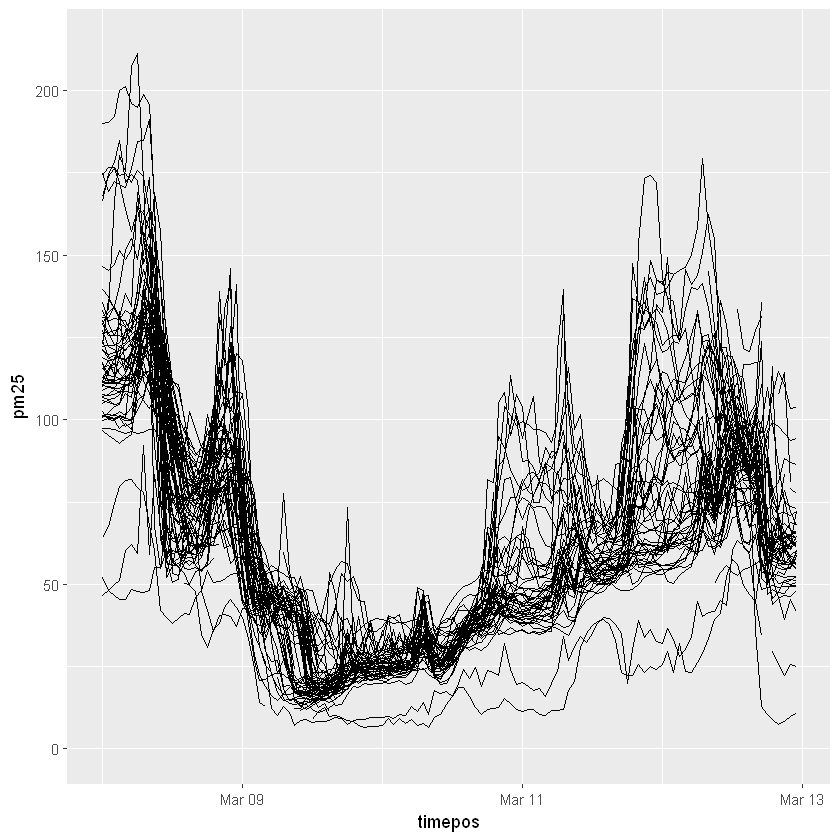

In [30]:
ggplot(data=newhour, aes(x=timepos, y=pm25, group=sensorid)) + geom_line()

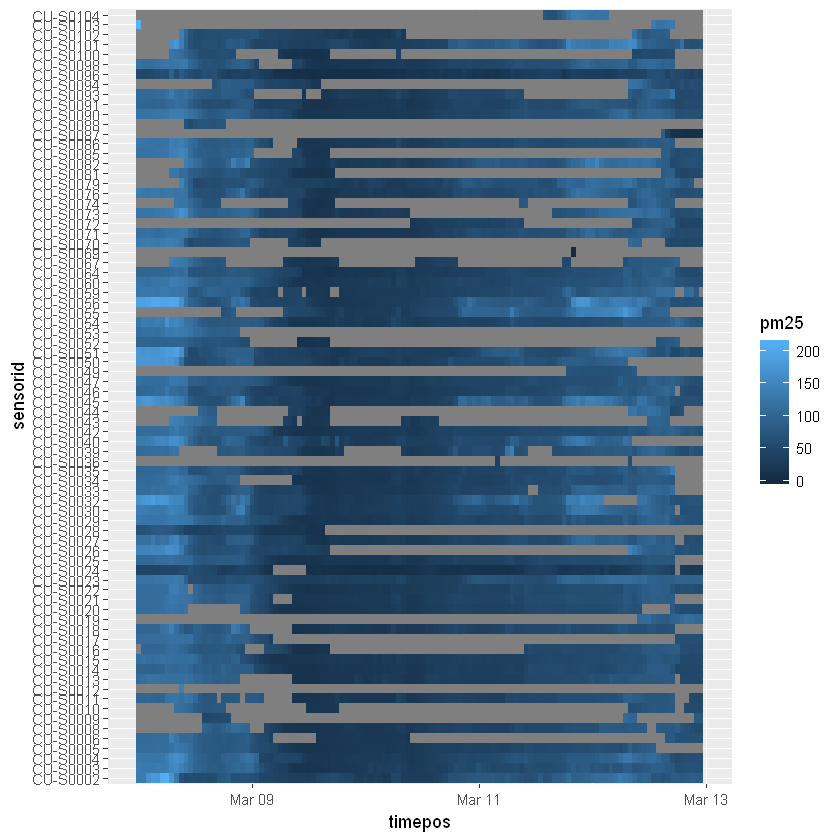

In [41]:
ggplot(data=newhour, aes(x=timepos, y=sensorid)) + geom_tile(aes(fill=pm25))

Count number of NA per id to check the completeness of data. เช็คว่าข้อมูลทุก sensor ว่ามี missing data ไปเท่าไหร่

In [55]:
count_na<-aggregate(pm25 ~ sensorid, data=newhour, function(x) {sum(is.na(x))}, na.action = NULL)
sensorFull<-count_na$sensorid[which(count_na$pm25<10)]
sensorFull

[1] CU-S0002 CU-S0003 CU-S0004 CU-S0014 CU-S0015 CU-S0022 CU-S0023 CU-S0024
 [9] CU-S0025 CU-S0027 CU-S0029 CU-S0030 CU-S0032 CU-S0033 CU-S0035 CU-S0042
[17] CU-S0045 CU-S0046 CU-S0047 CU-S0051 CU-S0054 CU-S0056 CU-S0059 CU-S0060
[25] CU-S0064 CU-S0071 CU-S0076 CU-S0090 CU-S0091 CU-S0096 CU-S0101
89 Levels: CU-S0002 CU-S0003 CU-S0004 CU-S0005 CU-S0006 CU-S0008 ... CU-S0104

Select only sensors that has 24 hour data

In [56]:
newhour<-subset(newhour,sensorid %in% sensorFull)

Check whether there is a weird value in the data.

In [57]:
sqldf("select sensorid, min(pm25), max(pm25), avg(pm25) from newhour group by sensorid")

sensorid,min(pm25),max(pm25),avg(pm25)
CU-S0002,25.000000,211.13542,73.69924
CU-S0003,15.791667,156.92708,64.94887
CU-S0004,20.197917,162.11458,69.84407
CU-S0014,14.238636,109.00000,51.41358
CU-S0015,14.718750,119.69792,52.64406
CU-S0022,15.919318,135.62500,56.56408
CU-S0023,30.479167,131.76042,69.24686
CU-S0024,6.471591,68.42708,26.68379
CU-S0025,14.854167,117.45833,51.93391
CU-S0027,15.968750,152.32955,62.09276


## Input into the model

The model use 3 inputs:
1. Unique datetime list in order (วันที่แบบเรียงลำดับ)
2. Unique sensorid in order (id แบบ เรียงลำดับ)
3. Sensor data order by sensorid and time respectively (ข้อมูลเรียงลำดับตาม id กับ เวลา เพื่อให้เชื่อมกับ 1 กับ 2)

In [58]:
datetime<-sqldf('select distinct(timepos) from newhour') #USE THIS
datetime<-as.data.frame(datetime[order(datetime$timepos),])
colnames(datetime)<-c("timepos")
sensorid<-subset(sensorlist,sensorid %in% sensorFull)
sensorid <- as.data.frame(sensorid[order(sensorid$sensorid),])
row.names(sensorid) = sensorid$sensorid

Create a SpatialPointsDataFrame

In [59]:
coordinates(sensorid)=~lon+lat
proj4string(sensorid)=CRS("+init=epsg:4326")

In [60]:
sensoridSP <- SpatialPoints(sensorid@coords,CRS("+init=epsg:4326")) 

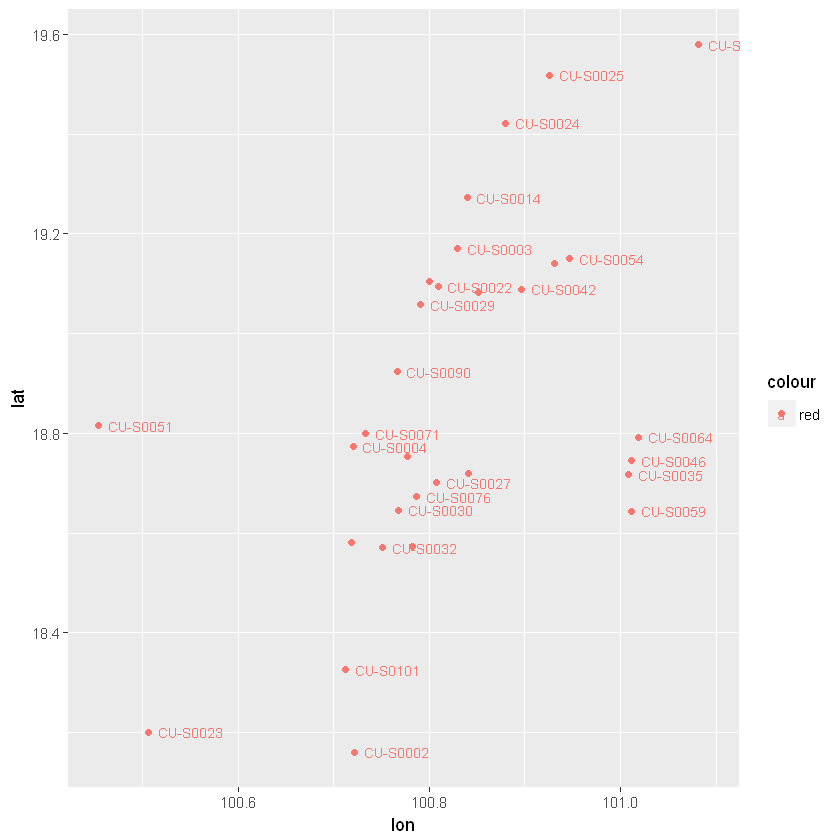

In [61]:
ggplot(data=as.data.frame(sensorid@coords), aes(x=lon, y=lat, color="red",label=rownames(as.data.frame(sensorid@coords))))+geom_point()+geom_text(hjust = 0, nudge_x = 0.01,size=3,check_overlap = TRUE)

Project lat/lon to UTM Zone 47

In [62]:
library(rgdal)
sensoridSP.UTM <- spTransform(sensoridSP, CRS("+init=epsg:32647"))

rgdal: version: 1.2-16, (SVN revision 701)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.0, released 2017/04/28
 Path to GDAL shared files: C:/Users/garavig/Documents/R/win-library/3.3/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/garavig/Documents/R/win-library/3.3/rgdal/proj
 Linking to sp version: 1.2-7 


Create spatio-temporal using STFDF function from spacetime library
STFDF ข้อมูลแหว่งได้

In [64]:
stdata<-STFDF(sensoridSP.UTM,datetime$timepos,data.frame(PM2.5=as.vector(newhour$pm25)),delta(datetime$timepos))

In [65]:
 summary(stdata)

Object of class STFDF
 with Dimensions (s, t, attr): (31, 120, 1)
[[Spatial:]]
Object of class SpatialPoints
Coordinates:
          min       max
lon  653277.9  718387.3
lat 2008840.6 2166302.0
Is projected: TRUE 
proj4string :
[+init=epsg:32647 +proj=utm +zone=47 +datum=WGS84 +units=m +no_defs
+ellps=WGS84 +towgs84=0,0,0]
Number of points: 31
[[Temporal:]]
     Index                       timeIndex     
 Min.   :2018-03-08 00:00:00   Min.   :  1.00  
 1st Qu.:2018-03-09 05:45:00   1st Qu.: 30.75  
 Median :2018-03-10 11:30:00   Median : 60.50  
 Mean   :2018-03-10 11:30:00   Mean   : 60.50  
 3rd Qu.:2018-03-11 17:15:00   3rd Qu.: 90.25  
 Max.   :2018-03-12 23:00:00   Max.   :120.00  
[[Data attributes:]]
     PM2.5        
 Min.   :  6.472  
 1st Qu.: 34.994  
 Median : 56.182  
 Mean   : 61.758  
 3rd Qu.: 82.659  
 Max.   :211.135  
 NA's   :54       

Then plot it

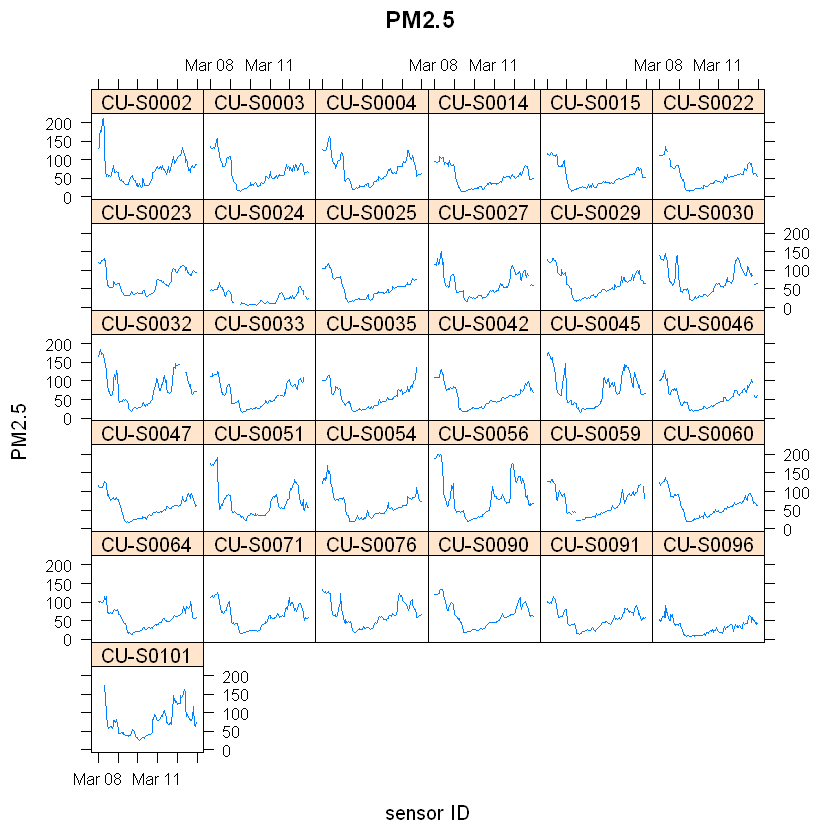

In [66]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")

scales <- list(x = list(rot = 45))
stplot(stdata,mode="tp",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

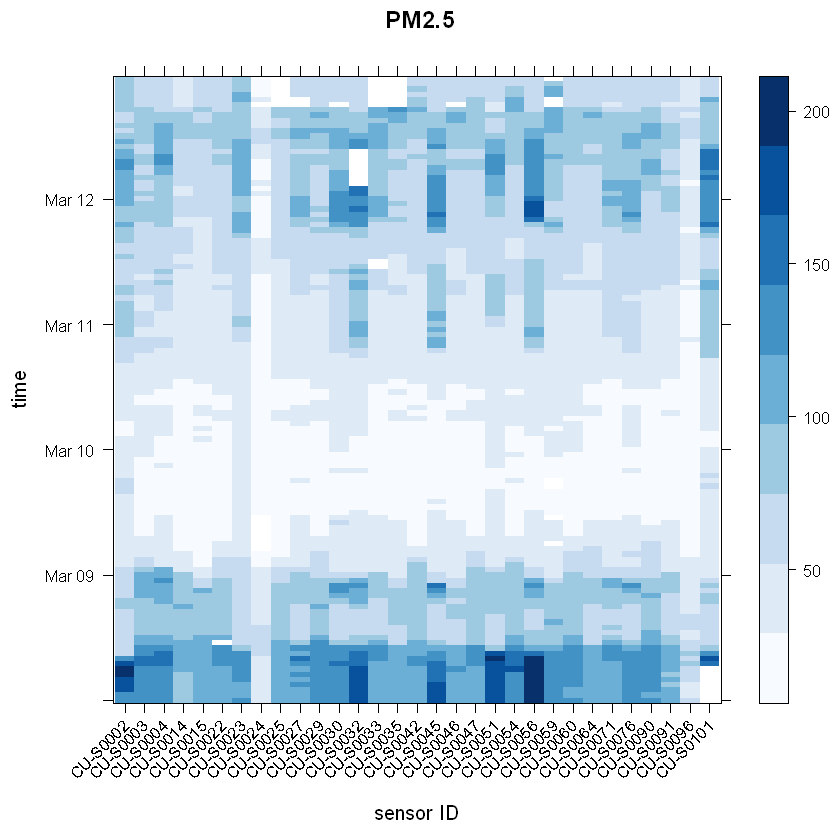

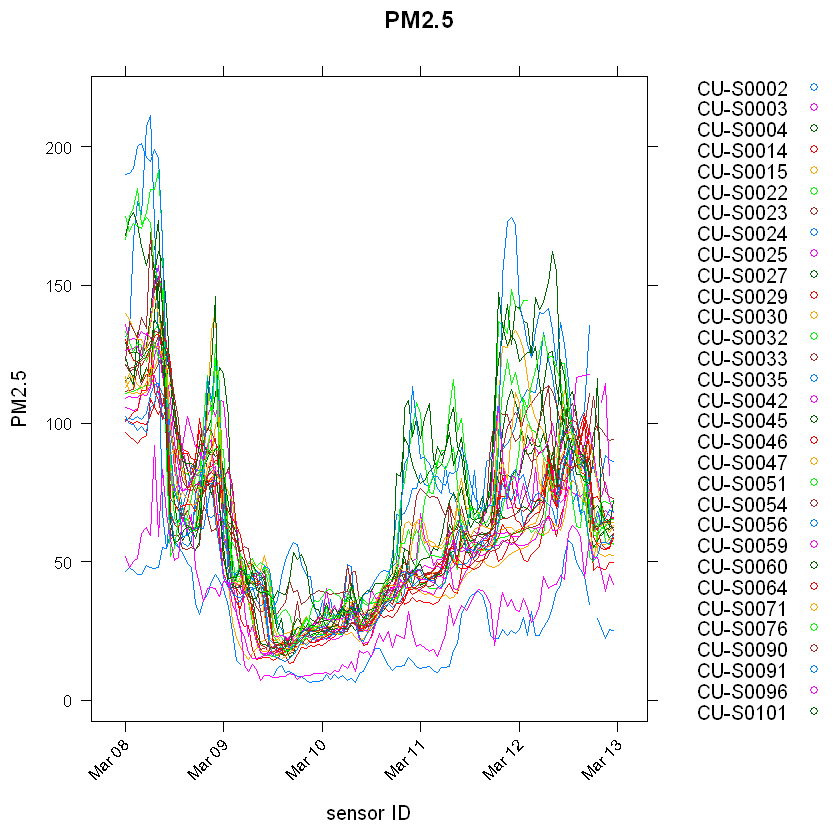

In [67]:
stplot(stdata,mode="xt",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)
stplot(stdata,mode="ts",scales=scales,xlab="sensor ID",col.regions = colorsetting)

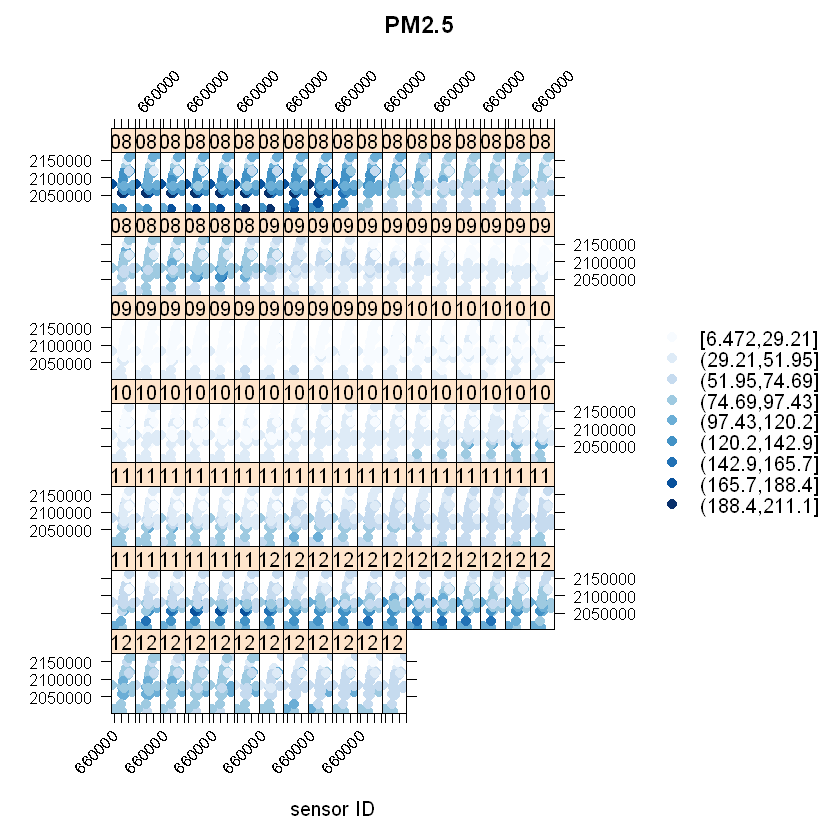

In [68]:
stplot(stdata,cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

In [69]:
print(spDists(stdata@sp),digits=3)

        [,1]   [,2]  [,3]   [,4]   [,5]   [,6]   [,7]   [,8]   [,9]  [,10]
 [1,]      0 112269 67749 123702 161572 103736  23246 140596 151790  60482
 [2,] 112269      0 45418  11433  52543   8635 112596  28411  39870  51944
 [3,]  67749  45418     0  56731  97058  36784  67285  73788  85288  12137
 [4,] 123702  11433 56731      0  42445  20008 123790  17062  28646  63365
 [5,] 161572  52543 97058  42445      0  60889 164277  27457  17754 101448
 [6,] 103736   8635 36784  20008  60889      0 103978  37033  48504  43524
 [7,]  23246 112596 67285 123790 164277 103978      0 140841 152424  63907
 [8,] 140596  28411 73788  17062  27457  37033 140841      0  11686  80167
 [9,] 151790  39870 85288  28646  17754  48504 152424  11686      0  91312
[10,]  60482  51944 12137  63365 101448  43524  63907  80167  91312      0
[11,]  99609  13002 32451  24283  65315   4429  99594  41338  52853  39580
[12,]  53931  58344 14905  69776 108495  49805  56551  86700  97968   7381
[13,]  45487  66824 22595

In [70]:
dim(stdata)

space      time variables 
       31       120         1

In [75]:
library(gstat)
vv = variogram(PM2.5~1, stdata, width=3500, tlags=0:6)

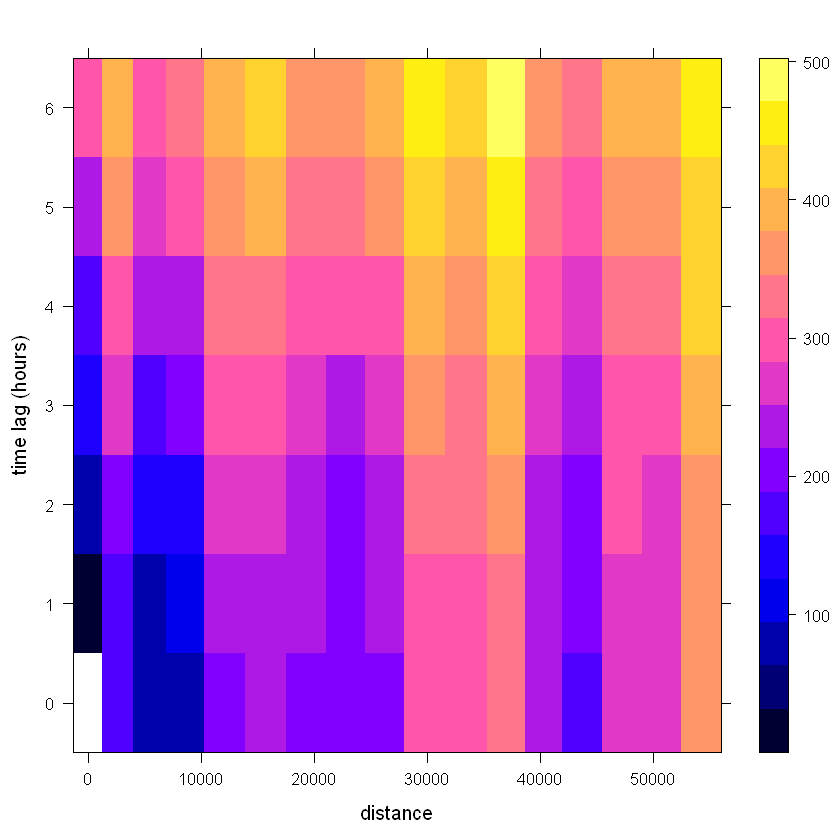

In [76]:
plot(vv)

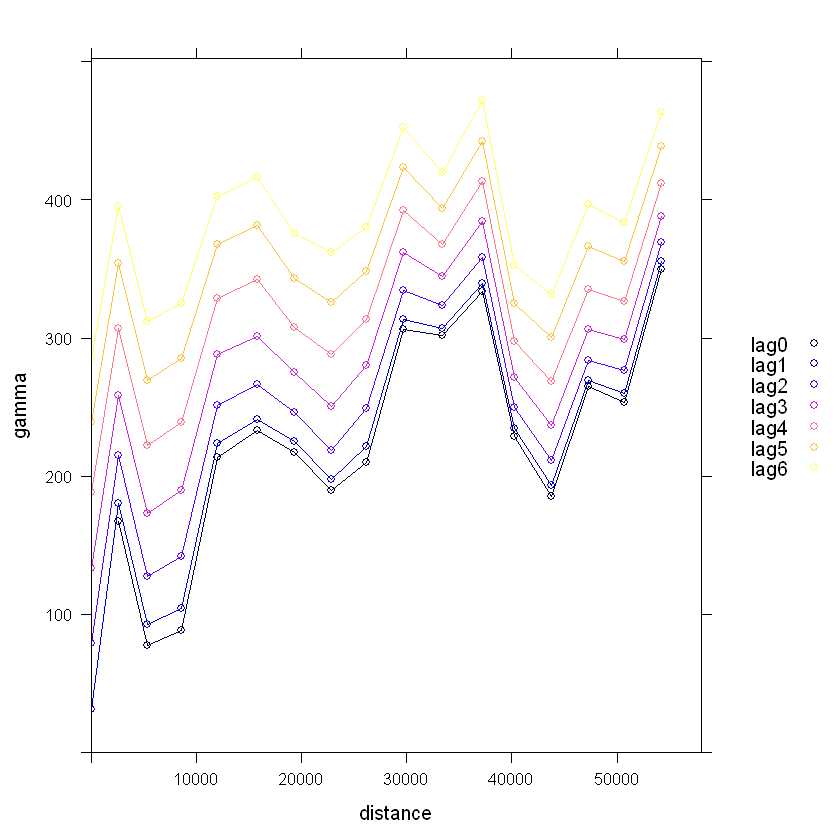

In [77]:
plot(vv, map = FALSE)

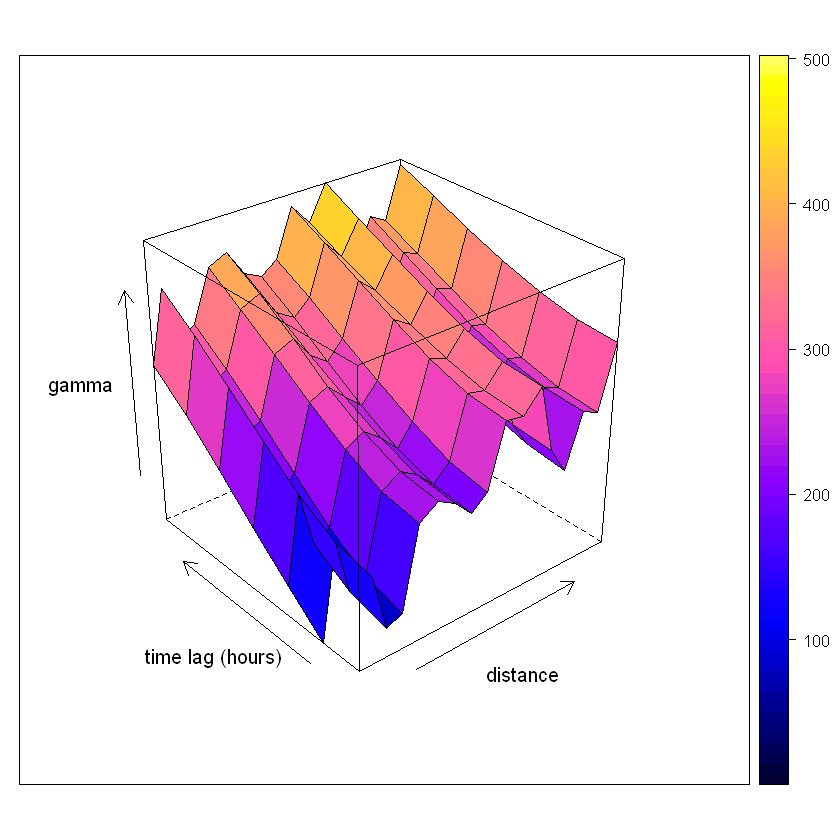

In [78]:
library(lattice)
plot(vv,all=T, wireframe=T)